# Floor Plan Optimization

## Context
The floorplan optimization seeks to find an optimal organization of machines on a factory floor to minimize the total travel time to produce a portfolio of parts. For each part in a catalog, we have:
* A volume of parts produced
* An ordered list of the machines operating on the materials to produce the part

The floorplan is shown below. We assume each machine has unit length/width and is only accessible on one side. Machines are accessed by an aisle, with 3 intersecting aisles at the top, middle, and bottom of the floorplan as seen in the image below.

<img src="Layout.png" alt="drawing" width="200"/>

## To Do:
* Add distances to mid and bottom, with shortest distance
* Speed up loop

In [1]:
import pandas as pd
import numpy as np
import random
from itertools import tee
import itertools
from dfply import *
import matplotlib.pyplot as plt

# Asset Definition
In this example, we will have 50 machines producing 3000 parts.

First a list of machines is generated.

In [2]:
# Machine List
machineList = ['M' + str(x) for x in range(0,50)]
print('Machines:')
print(machineList)

Machines:
['M0', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M19', 'M20', 'M21', 'M22', 'M23', 'M24', 'M25', 'M26', 'M27', 'M28', 'M29', 'M30', 'M31', 'M32', 'M33', 'M34', 'M35', 'M36', 'M37', 'M38', 'M39', 'M40', 'M41', 'M42', 'M43', 'M44', 'M45', 'M46', 'M47', 'M48', 'M49']


Next, we generate a list of parts and a build volume for each part.

In [3]:
# Part Table
## Each part has a key, volume, and list of machines
partTable = pd.DataFrame.from_dict({'PN': list(range(0,3000)),
                                    'Volume': np.random.exponential(5000, 3000)})

partTable.PN = partTable.PN.astype('O')

print('Part Table:')
print(partTable.head())

Part Table:
  PN        Volume
0  0   6243.462799
1  1    217.362516
2  2  10598.538551
3  3   3400.536810
4  4   2762.666297


In addition, each part gets a sequence of machine operations pulled from the machine list. The data is formated in melted format, i.e. each row describes the trip between machines.

In [4]:
# For each part, generate a list of machines to be visited

# Schema:
# pn  |  tripstart   | tripend
# 0   |  M1          | M2
# 0   |  M2          | M5


# Function to create pairwise list of machines
def pairwise(sequence):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iter(sequence))
    next(b, None)
    return zip(a, b)

# Provision an empty dataframe for results
partOperations = pd.DataFrame(columns=['PN', 'tripStartMachine', 'tripEndMachine'])

# For each part...
for PN in list(range(0,3000)):
    # Generate a sequence of operations (machines)
    operations = random.sample(machineList, np.random.randint(low=2, high=15))
    operations.insert(0, 'start')
    # Pariwise dataframe
    operations = pd.DataFrame(list(pairwise(operations)), columns=['tripStartMachine', 'tripEndMachine'])
    operations['PN'] = PN
    # Append to results dataframe
    partOperations = partOperations.append(operations, sort=False)

partOperations.head()

,PN,tripStartMachine,tripEndMachine
0,0,start,M18
1,0,M18,M20
2,0,M20,M42
3,0,M42,M31
4,0,M31,M35


Finally, we prescribe a floorplan with slots for at least as many machines as we have listed. Here we also measure distances between all slots. This calculation is done once so that we don't recalculate distances between machines on the fly.

In [5]:
# Floorplan

## Set parameters of layout
aisleCount = 10
machinesPerSide = 5

## Generate list of distances between each slot and each aisle
## Schema:
## slotID | aisle | position | dTop | dMid | dBot

## Generate coordinates
slotDistances = pd.DataFrame(list(itertools.product(list(range(aisleCount)), list(range((2*machinesPerSide) + 3)))),
                             columns=['aisle', 'position'])

## Measure distances
slotDistances['dTop'] = ((2*machinesPerSide) + 3 - 1) - slotDistances[['position']]
slotDistances['dBot'] = slotDistances[['position']]
slotDistances['dMid'] = np.abs(slotDistances[['position']] - (machinesPerSide + 1))

## Remove aisles
slotDistances = slotDistances[~slotDistances.position.isin([0, machinesPerSide+1, 2*machinesPerSide+2])]

## Add slot ID
slotDistances['slotID'] = range(0, len(slotDistances))
slotDistances.set_index('slotID', inplace=True)

slotIndex = slotDistances.index

# Pairwise slot distances
pairDistances = []
for x in list(itertools.product(slotDistances.index, slotDistances.index)):
    dTopA = slotDistances.dTop.loc[x[0]]
    dMidA = slotDistances.dMid.loc[x[0]]
    dBotA = slotDistances.dBot.loc[x[0]]
    aisleA = slotDistances.aisle.loc[x[0]]
    dTopB = slotDistances.dTop.loc[x[1]]
    dMidB = slotDistances.dMid.loc[x[1]]
    dBotB = slotDistances.dBot.loc[x[1]]
    aisleB = slotDistances.aisle.loc[x[1]]
    
    if aisleA == aisleB:
        dist = np.abs(dTopA - dTopB)
    else:
        dist = min((dTopA + dTopB), (dMidA + dMidB), (dBotA + dBotB)) + np.abs(aisleA - aisleB)
    
    pairDistances.append((x[0], x[1], dist))
    
# Convert to dataframe
pairDistances = pd.DataFrame(pairDistances, columns=['tripStartSlotID', 'tripEndSlotID', 'distance'])

# Add distances from start to each slot
startDistances = slotDistances[['dMid', 'aisle']].reset_index()
startDistances.columns = ['tripEndSlotID', 'dMid', 'aisle']
startDistances['distance'] = startDistances.dMid + startDistances.aisle + 1
startDistances['tripStartSlotID'] = 'start'
pairDistances = pairDistances.append(startDistances[['tripStartSlotID', 'tripEndSlotID', 'distance']], sort=False)

# Clean up typing
pairDistances['tripEndSlotID'] = pairDistances.tripEndSlotID.astype('O')

In [6]:
slotIndex

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
            85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64', name='slotID')

In [7]:
slotDistances.head()

,aisle,position,dTop,dBot,dMid
slotID,,,,,
0,0,1,11,1,5
1,0,2,10,2,4
2,0,3,9,3,3
3,0,4,8,4,2
4,0,5,7,5,1


In [8]:
pairDistances.tail()

,tripStartSlotID,tripEndSlotID,distance
95,start,95,11
96,start,96,12
97,start,97,13
98,start,98,14
99,start,99,15


# Assignment and Fitness

In [9]:
# Sample len(machine) slots from slot index to allocate machines to slots
slotAssignment = pd.DataFrame({'machineID': machineList, 
                               'slotID': random.sample(list(slotIndex), len(machineList))})

# Join a complete list of slotIDs to include blanks
slotAssignment = slotAssignment.merge(pd.DataFrame({'slotID': list(slotIndex)}), how='right').sort_values('slotID')

# Add start position
slotAssignment = slotAssignment.append(pd.DataFrame({'machineID': ['start'], 'slotID': ['start']}), sort=False)
slotAssignment = slotAssignment.reset_index(drop=True)

slotAssignment.head()

,machineID,slotID
0,M32,0
1,M17,1
2,NaN,2
3,NaN,3
4,M20,4


In [10]:
# Define the fitness function to measure quality of a solution
def costFunction(floorplan, partOps, pairDists, partVolumes):
    # Map machines in part ops to slots in floorplan
    fitnessCalc = partOps.merge(floorplan, how='left', left_on='tripStartMachine', right_on='machineID')
    fitnessCalc = fitnessCalc.merge(floorplan, how='left', left_on='tripEndMachine', right_on='machineID')
    ## Clean up the join
    fitnessCalc = fitnessCalc[['PN', 'tripStartMachine', 'tripEndMachine',
                              'slotID_x', 'slotID_y']]
    fitnessCalc.columns = ['PN', 'tripStartMachine', 'tripEndMachine',
                           'tripStartSlotID', 'tripEndSlotID']
    
    # Add distances between slot pairs
    fitnessCalc = fitnessCalc.merge(pairDists, how='left',
                                   on=['tripStartSlotID', 'tripEndSlotID'])
    
    # Part volume
    fitnessCalc = fitnessCalc.merge(partVolumes, how='left', on='PN')

    # calculate total travels
    fitnessCalc['weightedDistance'] = fitnessCalc.distance * fitnessCalc.Volume
    result = sum(fitnessCalc.weightedDistance)
        
    return(result)

# Test the fitness function on the initial configuration
initCost = costFunction(slotAssignment, partOperations, pairDistances, partTable)
print('Total Units Traveled in Init Configuration: {}'.format(initCost))

Total Units Traveled in Init Configuration: 978333584.321669


In [11]:
# Define function to swap n pairs of slots during annealing
def iteratePlan(floorplan, slots, n=2):
    while n > 0:
        # Take 2 slots at random
        slotsToSwap = random.sample(list(slots), 2)
        subdat = floorplan.loc[floorplan.slotID.isin(slotsToSwap), :]
        # Reverse order
        subdat.loc[:,'machineID'] = subdat.loc[:,'machineID'].values[::-1]
        # Replace in floorplan
        floorplan = floorplan.loc[~floorplan.slotID.isin(slotsToSwap), :]
        floorplan = floorplan.append(subdat)
        # Increment down
        n = n-1
    return(floorplan)

# See a sample swap
iteratePlan(slotAssignment, slotIndex).head()

c:\users\dagodbou\envs\sandbox\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,machineID,slotID
0,M32,0
1,M17,1
2,NaN,2
3,NaN,3
4,M20,4


c:\users\dagodbou\envs\sandbox\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\dagodbou\envs\sandbox\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\dagodbou\envs\sandbox\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


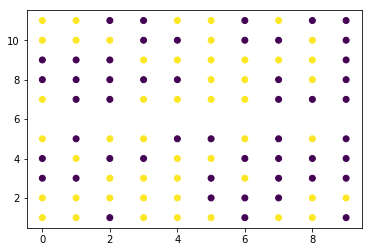

In [12]:
finalLayout = slotAssignment[~(slotAssignment.slotID == 'start')]
finalLayout.slotID = finalLayout.slotID.astype('int')

fillPlot = slotDistances.reset_index().merge(finalLayout, how='left')
fillPlot.machineID[fillPlot.machineID.notna()] = 1
fillPlot.machineID[fillPlot.machineID.isna()] = 0
fillPlot.machineID = fillPlot.machineID.astype(float)
fillPlot.head(10)
fillPlot.dtypes
plt.scatter(fillPlot.aisle, fillPlot.position, c = fillPlot.machineID)

## Annealing

In [13]:
# Initialize parameters
def acceptanceProbability(oldCost, newCost, temp):
    return np.exp((oldCost - newCost) / temp)

# Define annealer
def anneal(sol, partOps, pairDist, partTbl, slotIdx):
    #-------------------------------------------
    # Args:
    # sol: Current solution
    # partOps: Sequence of operations (machines) for each part
    # pairDist: Distances between all machine slots
    # partTbl: Part volumes
    # slotIdx: Map of machines to machine slots
    #--------------------------------------------
    
    # Initialize the annealer
    old_cost = costFunction(sol, partOps, pairDist, partTbl)
    T = 2000000
    Tmin = 5000
    alpha = 0.95 # Factor by which to decrement T
    Tsamples = 20 # How many iterations to run at a given T before lowering T
    Tlist = []
    Clist = []
    
    # Start main loop
    iloop = 1
    while T > Tmin:
        i = 1
        # For the current temperature T, run Tsamples iterations
        while i <= Tsamples:
            # Generate a new solution
            new_sol = iteratePlan(sol, slotIdx, n=1)
            # Calculate fitness of new solution
            new_cost = costFunction(new_sol, partOps, pairDist, partTbl)
            # Calculate acceptance probability and compare to random float
            ap = acceptanceProbability(old_cost, new_cost, T)
            if ap > random.random():
                # Accept new solution if better than old (ap >1), or randomly accepted
                sol = new_sol
                old_cost = new_cost
            i += 1
        print("Temperature: {}    | Score: {}".format(T, old_cost))
        # Add final temperature and cost of this 'epoch' to results list
        Tlist = Tlist + [iloop]
        Clist = Clist + [old_cost]
        T = T*alpha
        iloop += 1
    return sol, old_cost, Tlist, Clist

# Run the annealing function
finalLayout, cost, Tlist, Clist= anneal(slotAssignment, partOperations, pairDistances, partTable, slotIndex)

Temperature: 2000000    | Score: 974895664.6496623
Temperature: 1900000.0    | Score: 951611882.1696976
Temperature: 1805000.0    | Score: 947347961.6751214
Temperature: 1714750.0    | Score: 910957926.7630804
Temperature: 1629012.5    | Score: 897648664.69537
Temperature: 1547561.875    | Score: 872787393.9822781
Temperature: 1470183.78125    | Score: 872820987.5072173
Temperature: 1396674.5921874999    | Score: 873074683.6418761
Temperature: 1326840.8625781247    | Score: 856243296.5388408
Temperature: 1260498.8194492185    | Score: 853901206.2422045
Temperature: 1197473.8784767576    | Score: 844896461.6396888
Temperature: 1137600.1845529196    | Score: 844128754.2544875
Temperature: 1080720.1753252735    | Score: 843362980.3770101
Temperature: 1026684.1665590098    | Score: 834901373.9251829
Temperature: 975349.9582310593    | Score: 825081571.1987457
Temperature: 926582.4603195062    | Score: 819154925.8425817
Temperature: 880253.3373035309    | Score: 811025557.391921
Temperature

In [14]:
results = pd.DataFrame({'temperature': Tlist, 'cost': Clist})

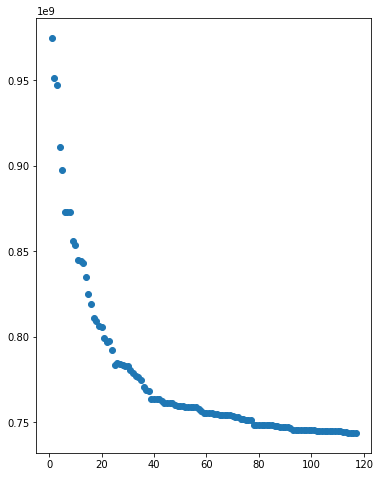

In [15]:
plt.figure(figsize=(6,8))
plt.scatter(results.temperature, results.cost)

In [16]:
print("Percent improvement over random: {}%".format(round(100 * (initCost - cost) / initCost,2)))

Percent improvement over random: 23.97%


c:\users\dagodbou\envs\sandbox\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\dagodbou\envs\sandbox\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


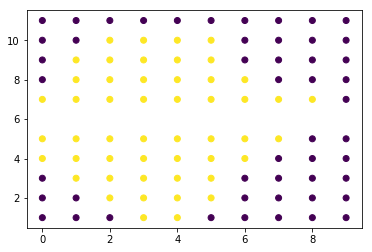

In [17]:
finalLayout = finalLayout[~(finalLayout.slotID == 'start')]
finalLayout.slotID = finalLayout.slotID.astype('int')

fillPlot = slotDistances.reset_index().merge(finalLayout, how='left')
fillPlot.machineID[fillPlot.machineID.notna()] = 1
fillPlot.machineID[fillPlot.machineID.isna()] = 0
fillPlot.machineID = fillPlot.machineID.astype(float)
fillPlot.head(10)
fillPlot.dtypes
plt.scatter(fillPlot.aisle, fillPlot.position, c = fillPlot.machineID)